/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 173 images belonging to 7 classes.
Found 40 images belonging to 7 classes.
Loaded the images of dataset-ANGRY

Loaded the images of dataset-DISGUST

Loaded the images of dataset-NEUTRAL

Loaded the images of dataset-FEAR

Loaded the images of dataset-SAD

Loaded the images of dataset-SURPRISE

Loaded the images of dataset-HAPPY




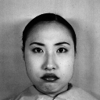
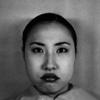
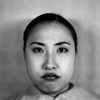
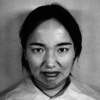
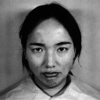
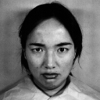
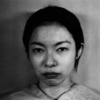
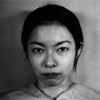
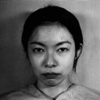
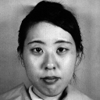
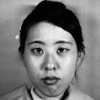
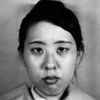
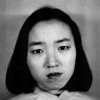
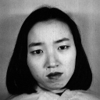
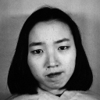
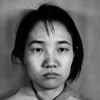
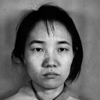
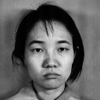
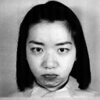
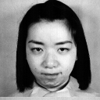
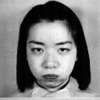
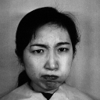
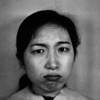
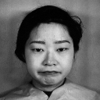
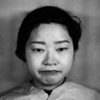
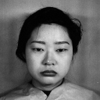
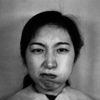
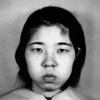
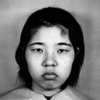
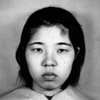
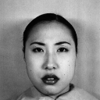
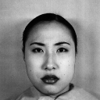
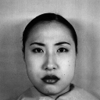
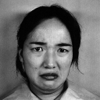
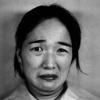
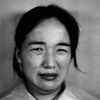
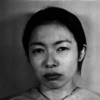
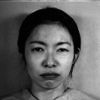
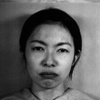
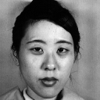
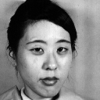
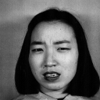
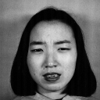
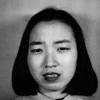
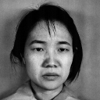
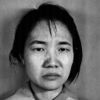
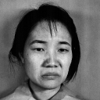
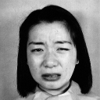
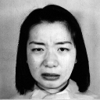
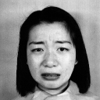
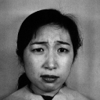
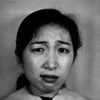
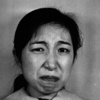
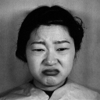
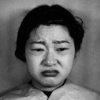
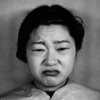
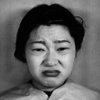
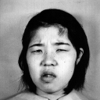
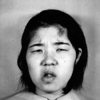
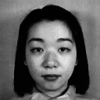
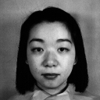
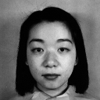
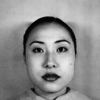
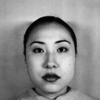
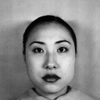
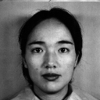
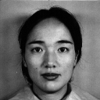
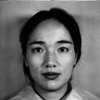
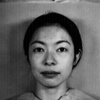
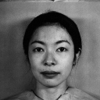
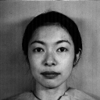
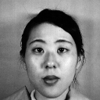
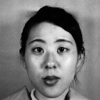
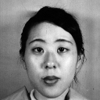
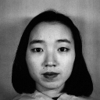
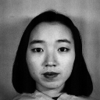
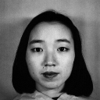
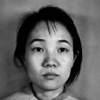
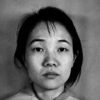
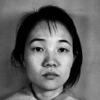
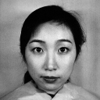
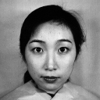
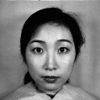
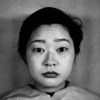
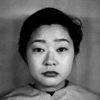
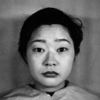
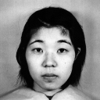
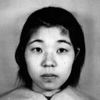
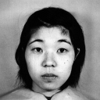
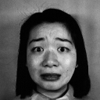
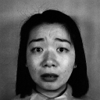
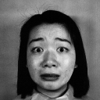
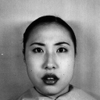
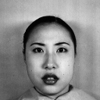
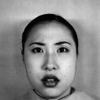
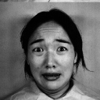
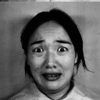
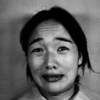
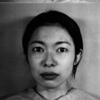
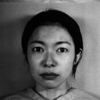
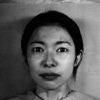
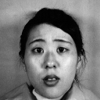
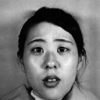
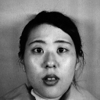
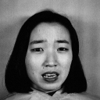
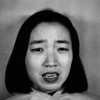
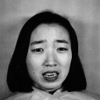
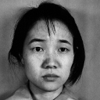
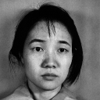
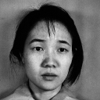
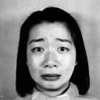
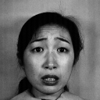
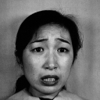
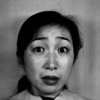
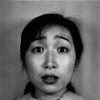
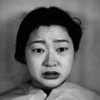
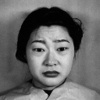
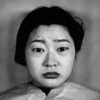
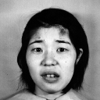
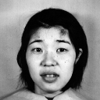
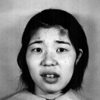
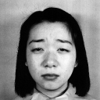
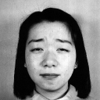
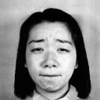
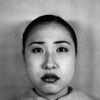
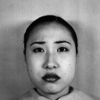
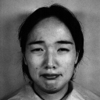
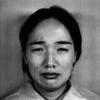
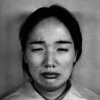
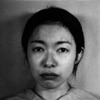
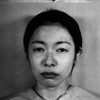
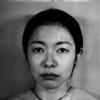
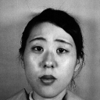
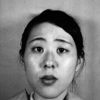
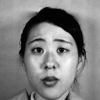
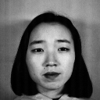
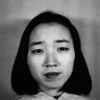
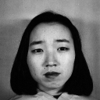
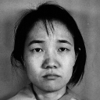
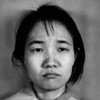
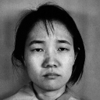
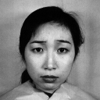
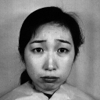
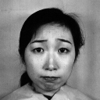
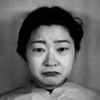
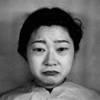
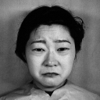
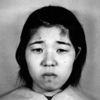
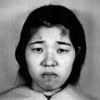
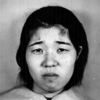
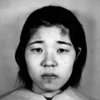
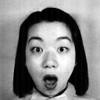
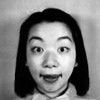
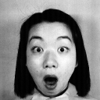
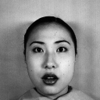
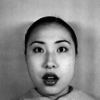
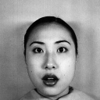
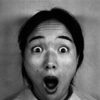
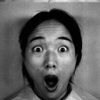
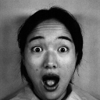
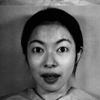
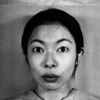
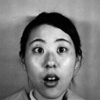
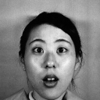
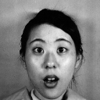
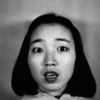
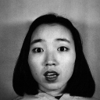
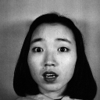
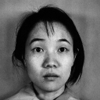
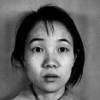
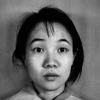
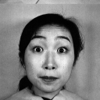
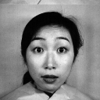
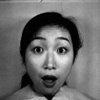
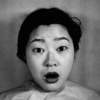
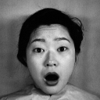
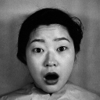
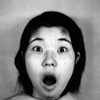
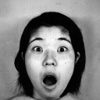
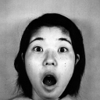
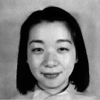
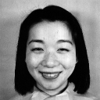
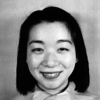
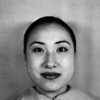
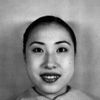
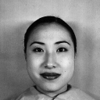
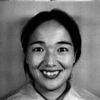
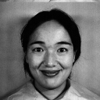
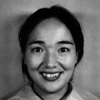
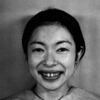
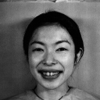
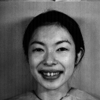
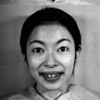
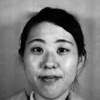
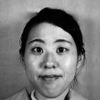
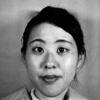
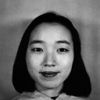
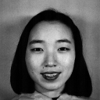
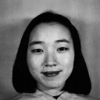
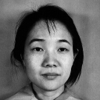
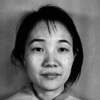
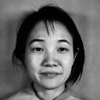
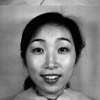
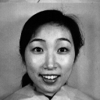
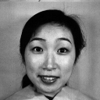
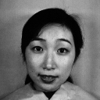
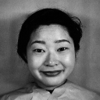
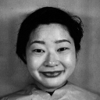
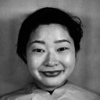
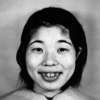
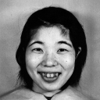
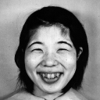
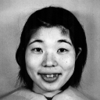


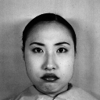
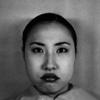
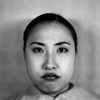
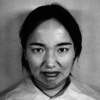
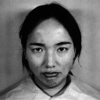
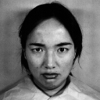
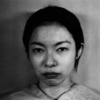
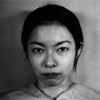
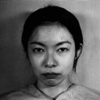
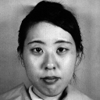
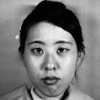
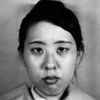
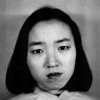
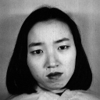
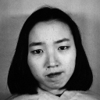
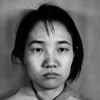
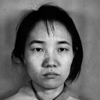
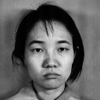
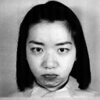
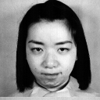
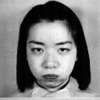
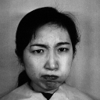
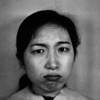
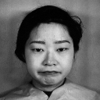
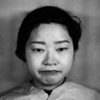
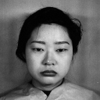
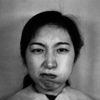
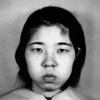
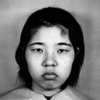
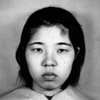
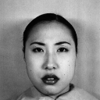
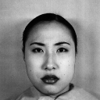
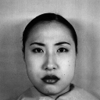
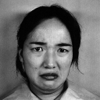
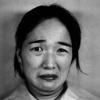
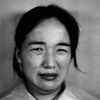
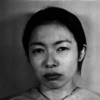
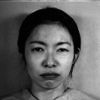
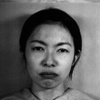
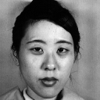
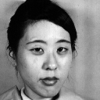
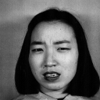
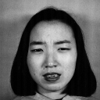
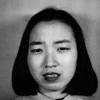
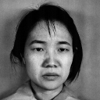
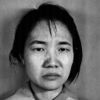
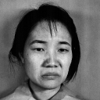
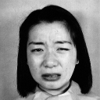
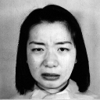
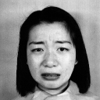
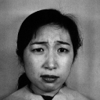
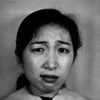
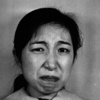
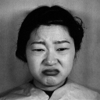
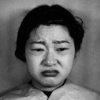
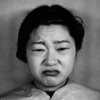
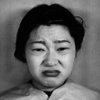
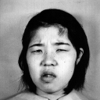
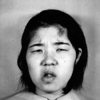
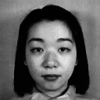
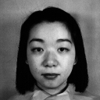
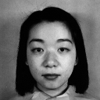
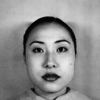
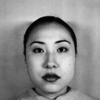
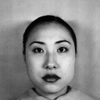
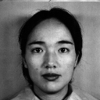
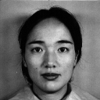
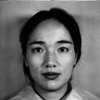
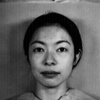
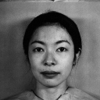
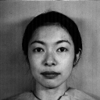
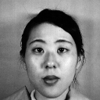
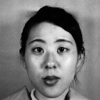
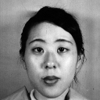
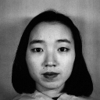
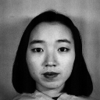
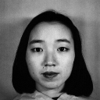
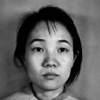
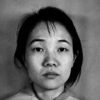
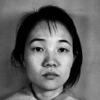
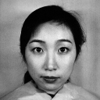
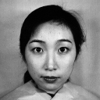
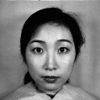
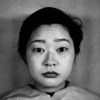
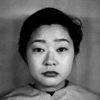
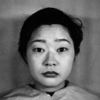
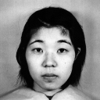
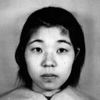
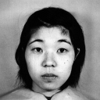
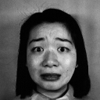
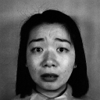
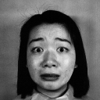
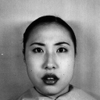
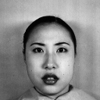
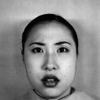
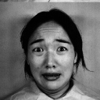
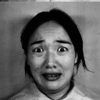
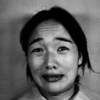
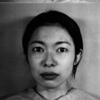
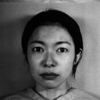
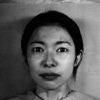
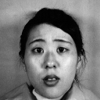
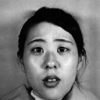
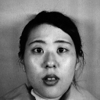
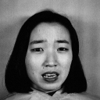
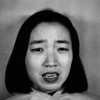
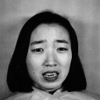
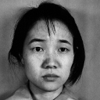
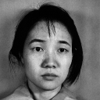
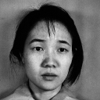
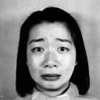
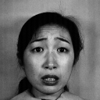
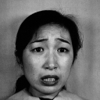
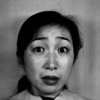
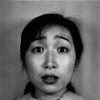
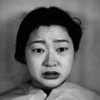
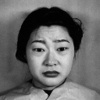
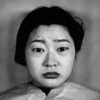
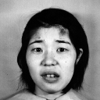
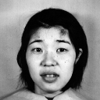
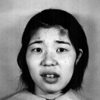
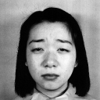
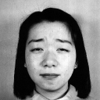
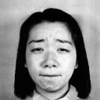
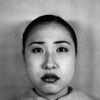
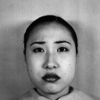
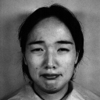
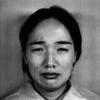
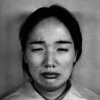
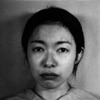
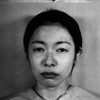
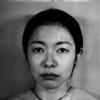
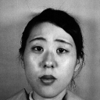
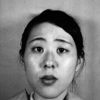
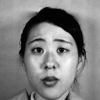
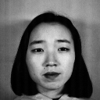
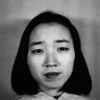
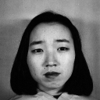
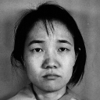
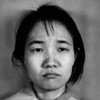
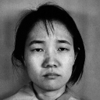
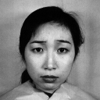
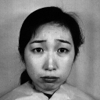
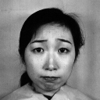
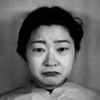
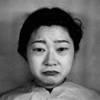
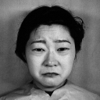
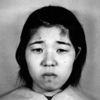
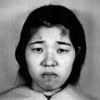
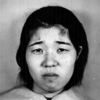
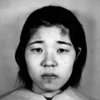
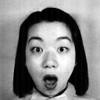
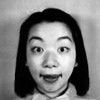
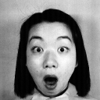
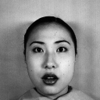
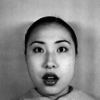
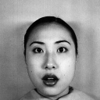
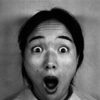
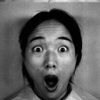
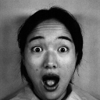
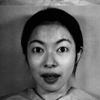
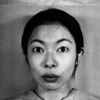
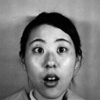
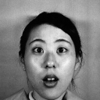
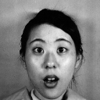
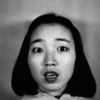
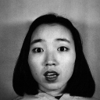
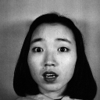
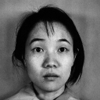
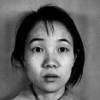
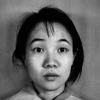
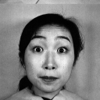
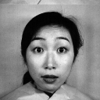
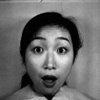
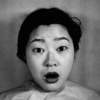
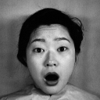
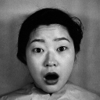
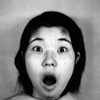
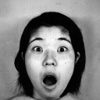
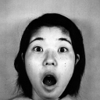
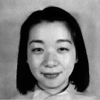
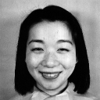
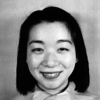
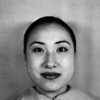
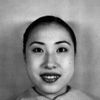
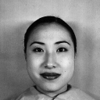
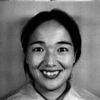
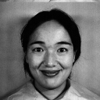
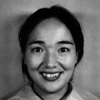
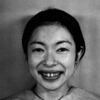
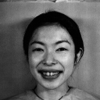
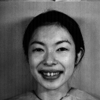
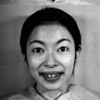
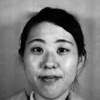
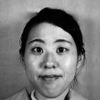
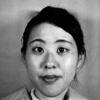
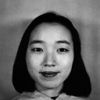
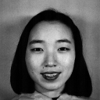
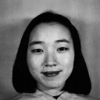
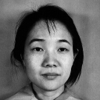
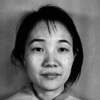
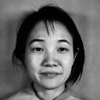
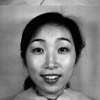
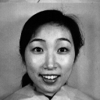
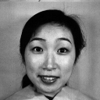
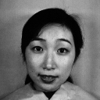
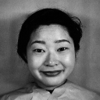
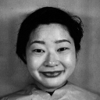
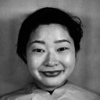
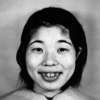
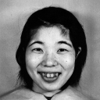
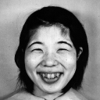
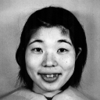

213
shape x train (181, 128, 128)
shape x train (181, 16384)
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_52 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_116 (Dense)            (None, 256)               16777472  
_________________________________________________________________
dense_117 (Dense)            (None, 7)                 1799      
Total params: 16,779,271
Trainable params: 16,779,271
Non-trainable params: 0
_________________________________________________________________
Number of components explaining 95% variance: 8


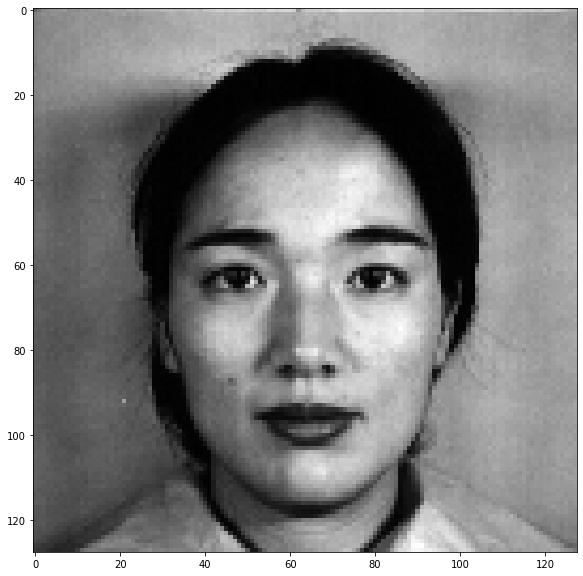

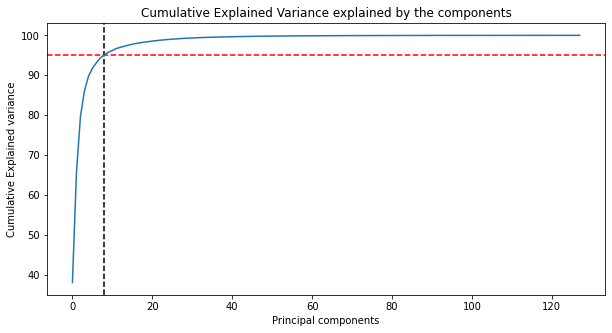

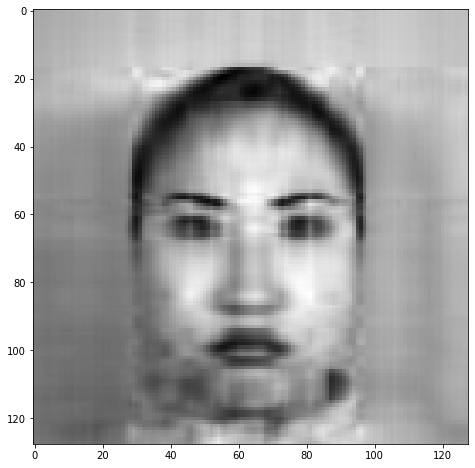

In [71]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
import ipyplot
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import load_model

import keras

from keras.utils import np_utils

from keras import backend as K
from keras import callbacks

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split

import keras

from keras.utils import np_utils

from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator

data_path = 'drive/MyDrive/jaffedbase'
data_dir_list = os.listdir(data_path)

img_rows = 256
img_cols = 256
nb_train_samples = 173
nb_validation_samples = 40
batch_size = 4 
epochs = 30

image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

train_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(256, 256), 
                                                 subset="training",
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(256, 256), 
                                                 subset="validation",
                                                 color_mode='grayscale',
                                                 class_mode='categorical')


img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img, cv2.IMREAD_GRAYSCALE)
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

ipyplot.plot_images(img_data_list, max_images=213, img_width=100)

num_classes = 7

num_of_samples = img_data.shape[0]
print(num_of_samples)
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:58]=1 #29
labels[59:91]=2 #33
labels[92:123]=3 #32
labels[124:150]=4 #27
labels[151:179]=5 #29
labels[180:]=6 #34

names = ['ANGRY','DISGUST','NEUTRAL','FEAR','SAD','SURPRISE','HAPPY']

def getLabel(id):
    return ['ANGRY','DISGUST','NEUTRAL','FEAR','SAD','SURPRISE','HAPPY'][id]


# convert class labels to on-hot encoding# conve 
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)


print('shape x train', X_train.shape)
X_train = X_train.reshape(X_train.shape[0], 128*128) 
X_test = X_test.reshape(X_test.shape[0], 128*128)
print('shape x train', X_train.shape)
image_0 = np.reshape(X_train[0], (128,128))
plt.imshow(image_0,cmap="gray")


model=Sequential()
model.add(Flatten(input_shape=(img_rows, img_cols,1)))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation=tf.nn.softmax))

model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('Emotion_train_model.h5',
                                 monitor='val_loss',
                                 mode='min',
                                 save_best_only=True,
                                 verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=9,
                              verbose=1,
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=3,
                                  verbose=1,
                                  min_delta=0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

history = model.fit_generator(
     train_dataset,
     steps_per_epoch=nb_train_samples // batch_size,
     epochs=epochs,
     validation_data=validation_dataset,
     callbacks=callbacks,
     validation_steps=nb_validation_samples // batch_size)


plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

pca = PCA()
pca.fit(img_data[0])

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)




# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)



In [2]:
pip install opencv-python ipyplot
